# Análise

In [40]:
# importando modulos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from plotly import express as px
from plotly import graph_objects as go
from scipy.stats import anderson, kstest, norm

In [41]:
def to_snake_cases(string: str) -> str:
  """
  Return the string in lower case with underscores format.
  """
  words_to_remove = [" de ", " da ", " dos ", " das ", " "]
  for word in words_to_remove:
    string = string.replace(word, "_")
  return string.lower()


In [42]:
# leitura dos dados
dict_columns = {
    "Sexo" : "string",
    "Idade": "int",
    "Cor": "string",
    "Anos de Estudo": "int",
    "Renda": "float",
    "Altura": "float",
}

dados = pd.read_excel("ibge2015.xlsx", dtype=dict_columns)
dados.head(10)

,Sexo,Idade,Cor,Anos de Estudo,Renda,Altura
0,Masculino,23,Parda,12,800.0,1.603808
1,Feminino,23,Branca,12,1150.0,1.739790
2,Feminino,35,Parda,15,880.0,1.760444
3,Masculino,46,Branca,6,3500.0,1.783158
4,Feminino,47,Parda,9,150.0,1.690631
5,Feminino,34,Parda,12,790.0,1.637906
6,Masculino,57,Parda,12,3150.0,1.570078
7,Feminino,60,Parda,12,1700.0,1.608495
8,Feminino,50,Preta,14,1800.0,1.780329
9,Masculino,26,Parda,12,1150.0,1.793203


In [43]:
# convertendo o nome das colunas do dataframe para lower case with underscores
dados.rename(
    columns={column: to_snake_cases(column) for column in dados.columns},
    inplace=True
)

## Tratamento de dados

In [44]:
# verificando valores nulos e o tipo das entradas
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72109 entries, 0 to 72108
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sexo         72109 non-null  string 
 1   idade        72109 non-null  int32  
 2   cor          72109 non-null  string 
 3   anos_estudo  72109 non-null  int32  
 4   renda        72109 non-null  float64
 5   altura       72109 non-null  float64
dtypes: float64(2), int32(2), string(2)
memory usage: 2.8 MB


In [45]:
# verificando linhas duplicadas
dados.duplicated().sum()

0

Este conjunto de dados foi tratado previamente

- Não há dados nulos
- Não há registros duplicados

## Análise da renda

In [46]:
renda = dados[['renda']]

In [47]:
renda.describe()

,renda
count,72109.000000
mean,1426.537214
std,1082.794549
min,0.000000
25%,788.000000
50%,1150.000000
75%,1900.000000
max,5000.000000


In [48]:
renda.std() / renda.mean() * 100

renda    75.903701
dtype: float64

In [49]:
renda.mode()

,renda
0,788.0


In [50]:
renda.quantile(
    np.arange(0, 1 + .1, .1)
)

,renda
0.0,0.0
0.1,300.0
0.2,700.0
0.3,788.0
0.4,950.0
0.5,1150.0
0.6,1400.0
0.7,1600.0
0.8,2000.0
0.9,3000.0


In [51]:
len(renda.query("renda <= 788")) / len(renda) * 100

30.761763441456687

### Conclusão Parcial

- 
- 80% da amostra recebe até R$ 2000,00
- Os 20% com mais renda da amostra recebem até 2.5 vezes mais que R$ 2000,00.

## Removendo outliers

In [52]:
q_25 = renda.quantile(.25)
q_75 = renda.quantile(.75)
iiq = q_75 - q_25
lim_inf = q_25 - 1.5*iiq
lim_sup = q_75 + 1.5*iiq

In [53]:
mask = (lim_inf <= renda) & (renda <= lim_sup)

In [54]:
renda1 = renda[mask]

In [55]:
renda1.describe()

,renda
count,67900.000000
mean,1240.568247
std,798.710304
min,0.000000
25%,788.000000
50%,1035.000000
75%,1600.000000
max,3565.000000


In [56]:
coef_var = renda1.std() / renda1.mean() * 100
str(coef_var.round(2).renda) + "%"

'64.38%'

## Distribuição de frequência da renda

Text(0.5, 1.0, 'Distribuição de frequência da renda')

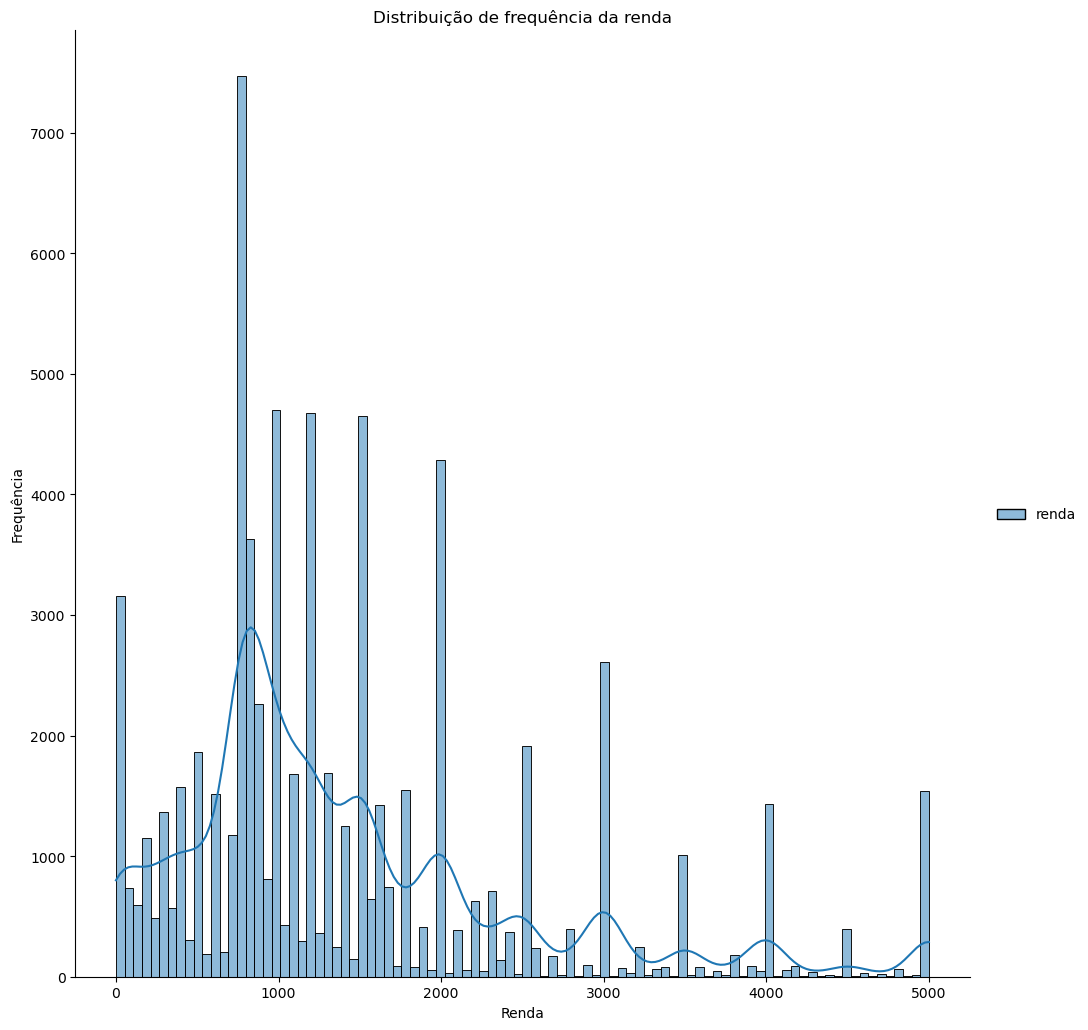

In [57]:
sns.displot(renda, kde=True, height=10)
plt.ylabel('Frequência')
plt.xlabel('Renda')
plt.title('Distribuição de frequência da renda')

Text(0.5, 1.0, 'Distribuição de frequência da renda')

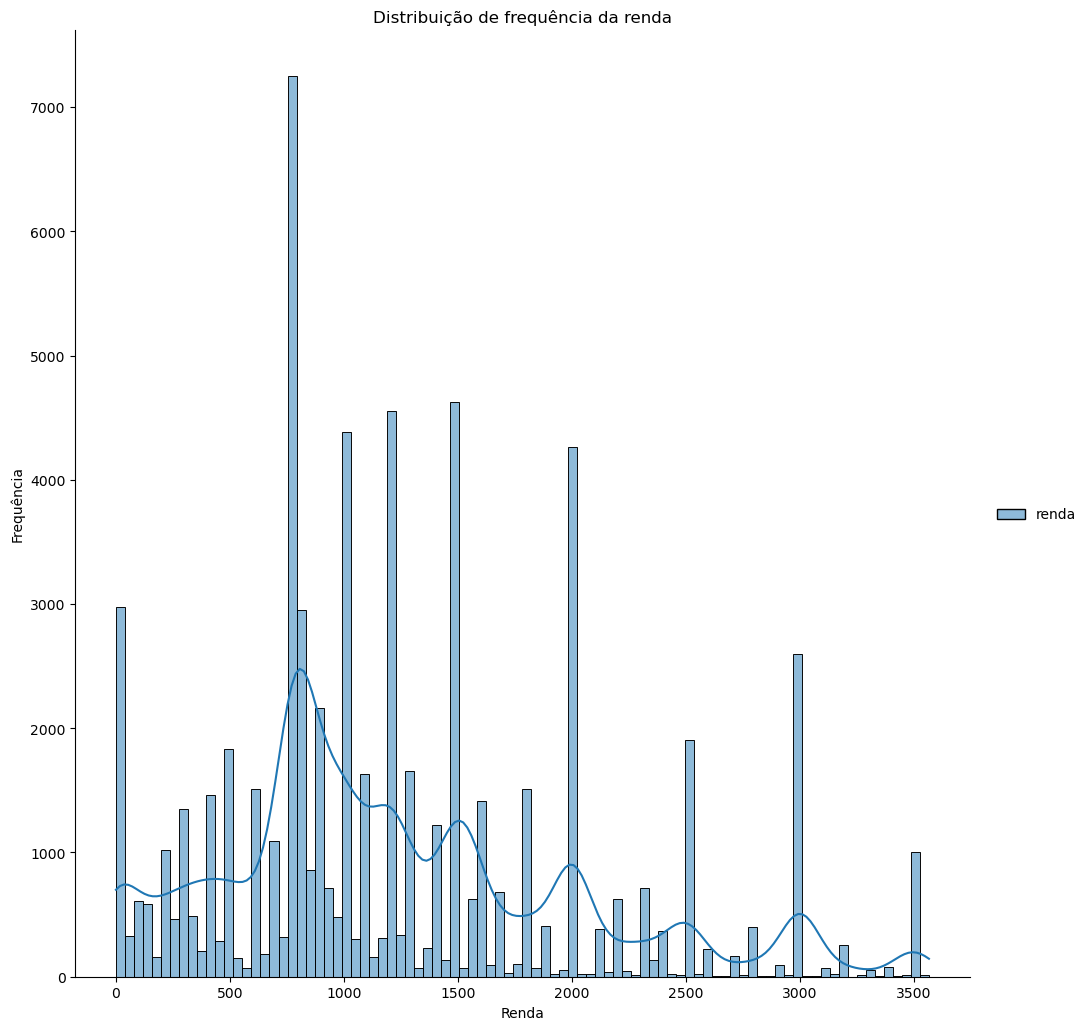

In [58]:
# distribuição de frequência com os outliers removidos
sns.displot(renda1, kde=True, height=10)
plt.ylabel('Frequência')
plt.xlabel('Renda')
plt.title('Distribuição de frequência da renda')

### Balancemento entre sexo

In [59]:
frequencia_sexo = dados[['sexo']].value_counts().to_frame()
frequencia_sexo.reset_index(inplace = True)
frequencia_sexo.rename(columns={'count': 'frequencia'},
                       inplace=True)
frequencia_sexo

,sexo,frequencia
0,Masculino,49553
1,Feminino,22556


In [60]:
proporcao_sexo = dados[['sexo']].value_counts(normalize=True).to_frame() * 100
proporcao_sexo.reset_index(inplace = True)
proporcao_sexo.rename(columns={'proportion': 'proporcao (%)'},
                      inplace=True)
proporcao_sexo

,sexo,proporcao (%)
0,Masculino,68.719577
1,Feminino,31.280423


In [61]:
distr_sexo = pd.merge(left=frequencia_sexo, how='inner',
                      on='sexo', right=proporcao_sexo)
distr_sexo

,sexo,frequencia,proporcao (%)
0,Masculino,49553,68.719577
1,Feminino,22556,31.280423


- Há um desbalancemento entre a quantidade de indivíduos homens e mulheres.
- A quantidade de homens é mais que o dobro das mulheres.

## Análise de renda entre homens e mulheres

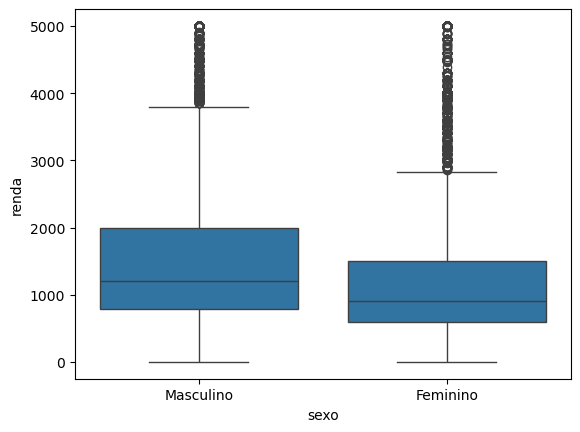

In [62]:
sns.boxplot(data=dados, x='sexo', y='renda')
plt.show("notebook")

In [63]:
renda_sexo = dados.groupby('sexo')[['sexo','renda']]
renda_sexo.describe()

renda                                                        \
             count         mean          std  min    25%     50%     75%   
sexo                                                                       
Feminino   22556.0  1181.701055   994.046245  0.0  600.0   900.0  1500.0   
Masculino  49553.0  1537.984037  1103.021757  0.0  788.0  1200.0  2000.0   

                   
              max  
sexo               
Feminino   5000.0  
Masculino  5000.0

- A média amostral da renda entre homens e mulheres diferem expressivamente.
- Podemos testar a hipótese que a renda média dos homens é maior que a das mulheres.

## Análise anos de estudo entre homens e mulheres

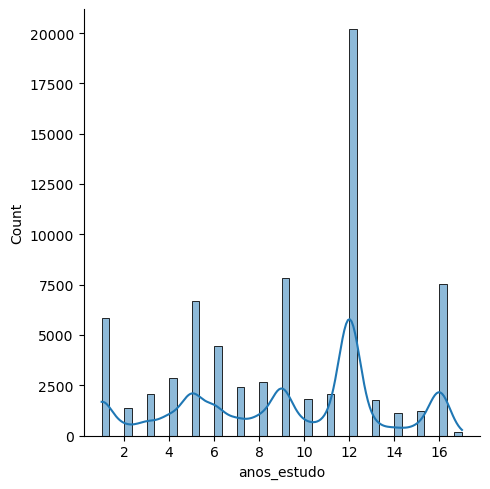

In [64]:
sns.displot(dados.anos_estudo, kde=True, height=5)

In [65]:
anos_estudo_sexo = dados.groupby('sexo')[['sexo','anos_estudo']]
anos_estudo_sexo.describe()

anos_estudo                                                 
                count       mean       std  min  25%   50%   75%   max
sexo                                                                  
Feminino      22556.0  10.023231  4.379938  1.0  6.0  12.0  12.0  17.0
Masculino     49553.0   8.733356  4.399562  1.0  5.0   9.0  12.0  17.0

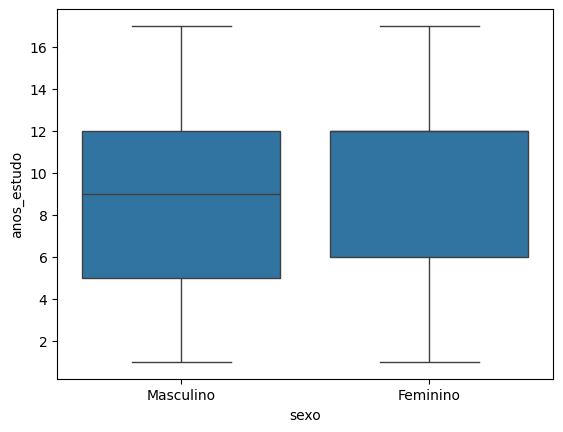

In [66]:
sns.boxplot(data=dados, x='sexo', y='anos_estudo')
plt.show("notebook")

In [67]:
anos_estudo_m = dados.query('sexo == "Masculino"').anos_estudo
anos_estudo_f = dados.query('sexo == "Feminino"').anos_estudo
ttest = stats.ttest_ind(anos_estudo_m, anos_estudo_f, equal_var = False)
ttest

TtestResult(statistic=-36.61354197756407, pvalue=4.083596917130119e-289, df=43823.0644233355)

- A amostra traz suspeitas que a renda média dos homens é maior que o das mulheres, mesmo com elas tendo, em média, mais anos de estudo que eles.

### Teste de hipótese
A diferença entre as médias é significativa, a ponto indicar fortemente que há uma diferença entre as médias populacionais da renda entre os homens e as mulheres.
Para confirmar essa hipótese, utilizaremos um método baseado em dados.

Como as variâncias populacionais são desconhecidas, utilizaremos a distribuição t-student.

Considere as hipóteses abaixo.

$ H_0:$ renda média dos homens $ = $ renda média das mulheres

$ H_1:$ renda média dos homens $ < $ renda média das mulheres

Nível de significância $\alpha = 0.5 $.

In [68]:
renda_m = dados.query('sexo == "Masculino"').renda
renda_f = dados.query('sexo == "Feminino"').renda

In [69]:
ttest2 = stats.ttest_ind(renda_m, renda_f, alternative='less', equal_var = False)
ttest2

TtestResult(statistic=43.091614419485914, pvalue=1.0, df=48051.9701494916)

Como p-valor é maior que 0.5, falhamos em rejeitar a hipótese nula.

In [70]:
ttest2.confidence_interval(confidence_level=.05)

ConfidenceInterval(low=-inf, high=342.68301236692366)

## Análise da correlação entre renda e anos de estudo

In [71]:
dados.select_dtypes(include='number').corr(method='pearson')

,idade,anos_estudo,renda,altura
idade,1.000000,-0.301891,-0.053125,-0.001253
anos_estudo,-0.301891,1.000000,0.448239,0.005731
renda,-0.053125,0.448239,1.000000,0.006117
altura,-0.001253,0.005731,0.006117,1.000000


In [72]:
# dados do sexo masculino
dados[dados.sexo == 'Masculino'].select_dtypes(include='number').corr()

,idade,anos_estudo,renda,altura
idade,1.000000,-0.312130,-0.051378,-0.000789
anos_estudo,-0.312130,1.000000,0.466243,0.006607
renda,-0.051378,0.466243,1.000000,0.008038
altura,-0.000789,0.006607,0.008038,1.000000


In [73]:
# dados do sexo feminino
dados[dados.sexo == 'Feminino'].select_dtypes(include='number').corr()

,idade,anos_estudo,renda,altura
idade,1.000000,-0.291420,-0.055338,-0.002359
anos_estudo,-0.291420,1.000000,0.511036,0.003187
renda,-0.055338,0.511036,1.000000,0.002726
altura,-0.002359,0.003187,0.002726,1.000000


### Conclusão Parcial

- Há uma correlação moderada entre renda e anos de estudo em todo o conjunto de dados, o conjunto de mulheres e o conjunto de homens.

#  Conclusão

- A distribuição de renda é assimétrica a direita (moda <= mediana <= média)
- A renda possuí uma alta variabilidade
- O salário mínimo é o mais frequente.
- 30,76% da amostra recebe até R$ 788,00, o salário mínimo.
- Os 80% mais pobres da amostra recebem até R$ 2000,00. Os 20% mais ricos da amostra recebem até 2.5 vezes este valor.
- Os homens recebem, em média, mais que as mulheres na população.
- Há uma correlação moderada entre renda e anos de estudo.

